In [1]:
"""
This is the behavior cloning project code I used for training. Though, to be,
fair, in the end performance depends mostly on the data. Also, this is just a 
copy paste from IPYTHON code

"""

import os
import argparse
import json

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.normalization import BatchNormalization

import numpy as np

import cv2
import csv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from pandas import ewma

from keras.utils import np_utils
from math import ceil
from math import pi

Using TensorFlow backend.


In [2]:
"""
I joined datasets using both UNIX and WINDOWS conventions, so this is needed
"""

dataset = "com"
dataset_val = "validation"
separator = "/"
separator2 = "\\"

In [3]:
"""
This function takes the dataset as argument and returns the driving log
"""

def getDrivingLog(datasetpath):
    with open('datasets/' + datasetpath + '/driving_log.csv','r') as f:
        datareader = csv.reader(f,delimiter=',')
        driving_log = []
        cnt = 0
        for row in datareader:
            if cnt > 0:
                driving_log.append(row)
            cnt = cnt + 1
    return driving_log

In [4]:
driving_log = getDrivingLog(dataset)
driving_log_val = getDrivingLog(dataset_val)

print(len(driving_log))
print(len(driving_log_val))

68314
2000


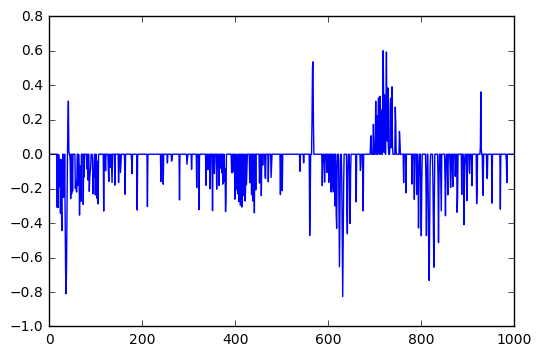

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


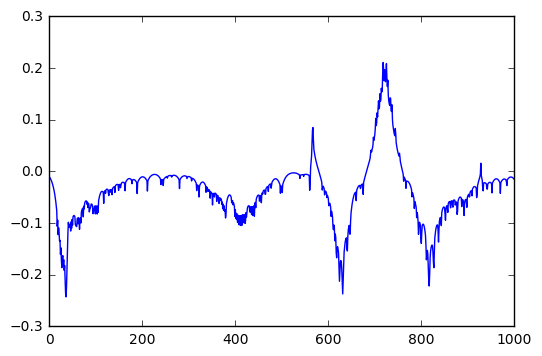

In [5]:
# Only filter validation stage
angles = [driving_log_val[j][3] for j in range(len(driving_log_val)) ] 
plt.plot(angles[0:1000])
plt.show()

angles_array = np.asarray(angles)
fwd = ewma(angles_array, span=16)
bwd = ewma(angles_array[::-1], span=16)
smooth = np.vstack((fwd, bwd[::-1]))
smooth = np.mean(smooth, axis=0)
angles_smooth = np.ndarray.tolist(smooth)

plt.plot(angles_smooth[0:1000])
plt.show()

# and substitute angles
for i in range(len(driving_log_val)):
    driving_log_val[i][3] = angles_smooth[i]

In [6]:
# Recover image shape
img_path     = 'datasets/' + dataset + '/IMG/' + driving_log[0][0].split(separator)[-1].split(separator2)[-1]
image_center = (mpimg.imread(img_path))[60:140,:,:]
image_shape  = image_center.shape

(80, 320, 3)


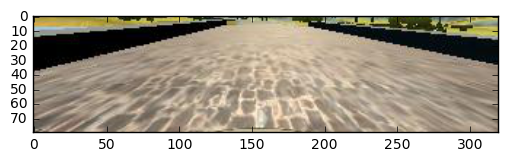

In [7]:
# and display shape
print(image_shape)

# and image
plt.imshow(image_center[0:80,:], cmap = 'gray') 
plt.show()

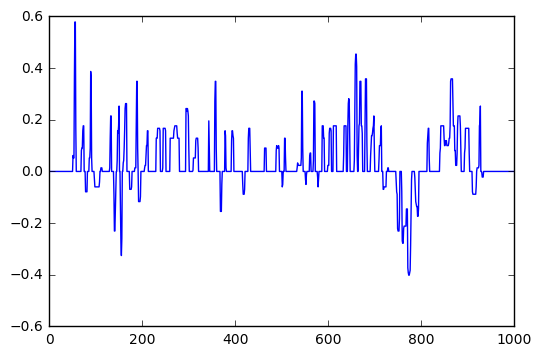

In [8]:
# Display section af angle data
angles = [driving_log[j][3] for j in range(len(driving_log)) ] 
plt.plot(angles[0:1000])
plt.show()

In [9]:
"""
BN is applies in the model as well, to also normalize per feature
"""

def normalize_channel(image_data):
    x_min = np.min(image_data)
    x_max = np.max(image_data)
    # Non extreme values are useful to avoid saturation for some act funcs
    a     = -0.5
    b     =  0.5
    return a + np.divide( (image_data - x_min ) * ( b - a), x_max - x_min) 

def preprocess_image(img):
    return normalize_channel(img) 

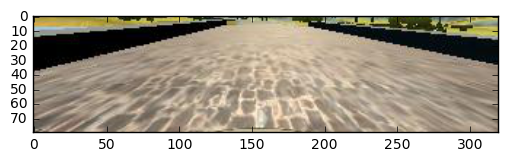

In [10]:
# Show original
plt.imshow(image_center) 
plt.show()

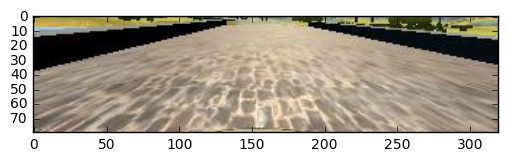

In [11]:
# Show after processing
plt.imshow(0.5 + preprocess_image(image_center)) 
plt.show()

In [12]:
scale_factor = 4
batch_size = 500
elements = 6
angle_factor = 0.75

In [13]:
def randomGenerator(datasetpath, drivinglog, number, forever=1):
    
    # We want to output at least number of elements in sections 
    # of batch_size elements
    total_ticks = ceil(number / batch_size)
    
    go_flag = 1
    while go_flag:
        go_flag = forever
        
        for i in range(total_ticks):
            
            # Create a random index.
            idx = np.random.choice(len(drivinglog),
                                   size=batch_size,
                                   replace=False)

            y_train   = np.zeros(  elements * (batch_size))
            x_train   = np.zeros(( elements * (batch_size), 
                                  ceil(image_shape[0]/scale_factor), 
                                  image_shape[1]/scale_factor, 
                                  3 ))
            
            ccidx = 0
            for j in idx:
                center_path = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][0].split(separator)[-1].split(separator2)[-1]
                left_path   = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][1].split(separator)[-1].split(separator2)[-1]
                right_path  = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][2].split(separator)[-1].split(separator2)[-1]
                # Get offset angles for sides
                center_ang  = float(driving_log[j][3])
                flipped_ang = -center_ang
                left_ang    = center_ang + abs(center_ang * angle_factor) + 6 * pi / 180.0
                right_ang   = center_ang - abs(center_ang * angle_factor) - 6 * pi / 180.0
                # Read images, this is kind of our randomization-ish
                image_center = (mpimg.imread(center_path))[60:140,:,:]
                image_flip   = (cv2.flip(image_center, 1))
                image_left   = (mpimg.imread(left_path))[60:140,:,:]
                image_right  = (mpimg.imread(right_path))[60:140,:,:]
                image_left_flip  = (cv2.flip(image_left, 1))
                image_right_flip = (cv2.flip(image_right, 1))
                # Resize them
                image_center = cv2.resize(image_center, (0,0), fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR )
                image_flip   = cv2.resize(image_flip,   (0,0), fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR ) 
                image_left   = cv2.resize(image_left,   (0,0), fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR )
                image_right  = cv2.resize(image_right,  (0,0), fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR )
                image_left_flip   = cv2.resize(image_left_flip,   (0,0), fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR )
                image_right_flip  = cv2.resize(image_right_flip,  (0,0), fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR )
                # Preprocess
                image_center = preprocess_image(image_center)
                image_flip   = preprocess_image(image_flip)
                image_left   = preprocess_image(image_left)
                image_right  = preprocess_image(image_right)
                image_left_flip   = preprocess_image(image_left_flip)
                image_right_flip  = preprocess_image(image_right_flip)
                # pass to x_train
                x_train[ccidx,     :, :, :] = image_center[:,:,:]
                x_train[ccidx + 1, :, :, :] = image_flip[:,:,:]
                x_train[ccidx + 2, :, :, :] = image_left[:,:,:]
                x_train[ccidx + 3, :, :, :] = image_right[:,:,:]
                x_train[ccidx + 4, :, :, :] = image_left_flip[:,:,:]
                x_train[ccidx + 5, :, :, :] = image_right_flip[:,:,:]
                # append to our list of Y
                y_train[ccidx    ] = center_ang
                y_train[ccidx + 1] = flipped_ang
                y_train[ccidx + 2] = left_ang
                y_train[ccidx + 3] = right_ang
                y_train[ccidx + 4] = -left_ang
                y_train[ccidx + 5] = -right_ang
                # Update count
                ccidx = ccidx + elements
            yield x_train, y_train

In [14]:
np.random.seed(1)
x_test, y_test = next(randomGenerator(dataset, driving_log, 1000, 0))

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
np.random.seed(1)
x_val, y_val = next(randomGenerator(dataset_val, driving_log_val, 1000, 0))

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(3000, 20, 80, 3)
[-0.3398304   0.3398304   0.01976216 -0.69942296 -0.01976216  0.69942296]


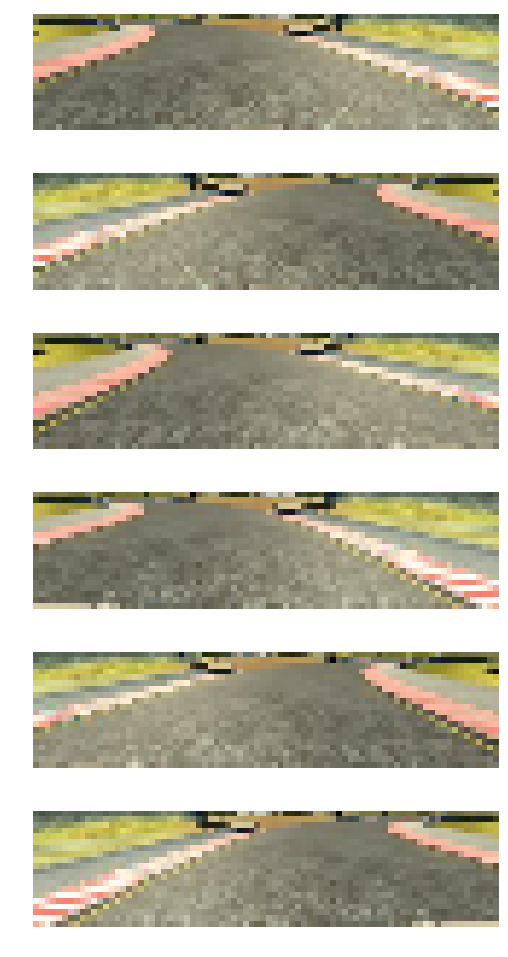

In [16]:
# Show some images from sets

print(x_test.shape)
print(y_test[0:6])

fig = plt.figure(figsize=(6,12))

fig.add_subplot(6,1,1)
plt.imshow((0.5 + x_test[0][:,:,:]), cmap='gray', interpolation="nearest")
plt.axis('off')

fig.add_subplot(6,1,2)
plt.imshow((0.5 + x_test[1][:,:,:]), cmap='gray', interpolation="nearest")
plt.axis('off')

fig.add_subplot(6,1,3)
plt.imshow((0.5 + x_test[2][:,:,:]), cmap='gray', interpolation="nearest")
plt.axis('off')

fig.add_subplot(6,1,4)
plt.imshow((0.5 + x_test[3][:,:,:]), cmap='gray', interpolation="nearest")
plt.axis('off')

fig.add_subplot(6,1,5)
plt.imshow((0.5 + x_test[4][:,:,:]), cmap='gray', interpolation="nearest")
plt.axis('off')

fig.add_subplot(6,1,6)
plt.imshow((0.5 + x_test[5][:,:,:]), cmap='gray', interpolation="nearest")
plt.axis('off')

plt.show()

In [17]:
model = Sequential()

input_shape = (ceil(image_shape[0]/scale_factor), image_shape[1]/scale_factor, 3)

# Check link https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
# for why BN is after activation

model.add(BatchNormalization(input_shape=input_shape))

# See https://arxiv.org/pdf/1606.02228v2.pdf
model.add(Convolution2D(10, 1, 1, subsample=(1, 1), border_mode="same", init = "he_normal"))
model.add(Activation('elu'))
model.add(Convolution2D(3,  1, 1, subsample=(1, 1), border_mode="same", init = "he_normal"))
model.add(Activation('elu'))
# Convert to single color space, hopefully works better, like the R channel from images
# This is nonsense, you would only constrain the 'linkedness' of the NN by doing this, 
# and thus its possible max predictive power!, though easier for humans to imagine, this
# simplification is not needed for a NN at all!. Steps above are only ever done to avoid
# choosing any color space and let the NN do it itself. conv1x1x3→conv1x1x3 could work too
#model.add(Convolution2D(1,  1, 1, subsample=(1, 1), border_mode="same", init = "he_normal"))
#model.add(Activation('elu'))
# And renormalize
# These later BN layers lead to horrible unusable NNs, I blame bad data
#model.add(BatchNormalization())

model.add(Convolution2D(60, 3, 3, subsample=(1, 1), border_mode="same", init = "he_normal"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('elu'))
# These later BN layers lead to horrible unusable NNs, I blame bad data
#model.add(BatchNormalization())

model.add(Convolution2D(90, 3, 3, subsample=(1, 1), border_mode="same", init = "he_normal"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('elu'))
# These later BN layers lead to horrible unusable NNs, I blame bad data
#model.add(BatchNormalization())

# final reductions in size
model.add(Convolution2D(120, 3, 3, subsample=(1, 1), border_mode="valid", init = "he_normal"))
model.add(MaxPooling2D(pool_size=(1,3)))
model.add(Activation('elu'))
# mmm...
#model.add(Convolution2D(128, 3, 3, subsample=(1, 1), border_mode="valid", init = "he_normal"))
#model.add(Activation('elu'))

# A a bit of dropout to avoid overfitting
model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(640, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(320, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(160, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(80, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(20, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 20, 80.0, 3)   6           batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 20, 80.0, 10)  40          batchnormalization_1[0][0]       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 20, 80.0, 10)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 80.0, 3)   33          activation_1[0][0]               
___________________________________________________________________________________________

In [18]:
low_adam = Adam(lr=0.00001)
model.compile(optimizer=low_adam, loss="mse")

[[-0.00458217]]


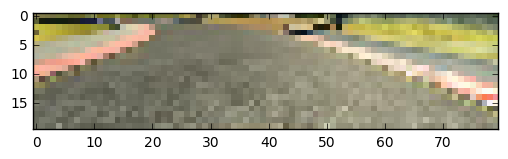

In [19]:
"""
Test for a single image
"""
image_center = x_test[0]
transformed_image_array = image_center[None, :, :, :]
print(model.predict(transformed_image_array, batch_size=1))
plt.imshow(0.5 + image_center, interpolation="nearest")
plt.show()

In [21]:
#Plase take note, that I manually test each epoch of the network, since training
#time is so long, it was best for me to test it immediately to avoid wasting
#so much time. Testing takes relatively little time. Also allowsbbb to easily
#identify diggicult sections
#
#Load saved model to retrain
model = load_model('weights-improvement-14-0.02513.hdf5')

In [22]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

In [23]:
model.fit_generator(randomGenerator(dataset, driving_log, 20000), 
                    samples_per_epoch = elements * 20000, 
                    nb_epoch=2, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=randomGenerator(dataset_val, driving_log_val, 2000), 
                    nb_val_samples = elements * 2000, 
                    class_weight=None, 
                    nb_worker=1)

Epoch 1/2


C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


120000/120000 [==============================] - 948s - loss: 0.0421 - val_loss: 0.0276
Epoch 2/2
120000/120000 [==============================] - 899s - loss: 0.0388 - val_loss: 0.0278


In [ ]:
# Save for later
model.save('modelSingle.h5')

In [ ]:
"""
Execute only on finalization, to save for review
"""
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")